## Regional Satellite / WRF-Chem comparison script

Bulk work, to combine data for each season, rather than plotting a single day at a time.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
from matplotlib import ticker
from matplotlib import interactive
interactive(True)

import xarray as xr
import numpy as np
import pandas as pd

from scipy import stats

from datetime import timedelta, date
import datetime

In [2]:
# date range function from stackoverflow: 
#   https://stackoverflow.com/questions/1060279/iterating-through-a-range-of-dates-in-python
#   (same source is used for the date range iteration below too)
def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

In [3]:
# loads column and lat/lon data, and converts to panda array.
#    This includes copying the time index to our model data, because
#    I had not added this to the model netcdf files when creating them.
def load_create_dataframe(sat_datadask,model_datadask):

    sat_col_data = sat_datadask.column.copy(deep=True)
    sat_error_data = sat_datadask.error.copy(deep=True)
    sat_vprof_data = sat_datadask.VertProf.copy(deep=True)
    sat_clcov_data = sat_datadask.CLcov.copy(deep=True)
    sat_angle_data = sat_datadask.angle.copy(deep=True)
    lat_data = sat_datadask.latitude.copy(deep=True)
    lon_data = sat_datadask.longitude.copy(deep=True)
    
    # convert from xarray to pandas dataframe
    cold = sat_col_data.to_dataframe()
    errd = sat_error_data.to_dataframe()
    verd = sat_vprof_data.to_dataframe()
    clcd = sat_clcov_data.to_dataframe()
    angd = sat_angle_data.to_dataframe()
    latd = lat_data.to_dataframe()
    lond = lon_data.to_dataframe()
     
    # load the model data, convert to pandas
    model_nh3_data = model_datadask.nh3.copy(deep=True)
    model_date_data = model_datadask.date.copy(deep=True)
    nh3d = model_nh3_data.to_dataframe()
    dat_temp_d = model_date_data.to_dataframe()
    #dat_temp_d.column = ['full_date']
    
    # FUTURE WORK: split the date information into date and hour
    #date2d = dat_temp_d.datetime.strftime('%m/%d/%Y')
    #date2d.column = ['date']
    #hour2d = dat_temp_d.datetime.strftime('%H:%M:%S.%f')
    #hour2d.column = ['time_of_day']
    
    #result_temp = pd.concat([nh3d,dated,hourd,cold,errd,verd,clcd,angd,latd,lond], axis=1, sort=False)
    result_temp = pd.concat([dat_temp_d,nh3d,cold,errd,verd,clcd,angd,latd,lond], axis=1, sort=False)
    
    # switch index from time to date
    result = result_temp.reset_index(drop=False).set_index(['date','latitude','longitude'])

    return result

In [4]:
# Loading data files from a list.
def load_and_combine_list_of_files(satellite_file_path,model_file_path,start_date,end_date):
    
    # initalise list for storing datasets to append
    data_to_append = []  # https://stackoverflow.com/questions/28669482/appending-pandas-dataframes-generated-in-a-for-loop

    for single_date in daterange(start_date, end_date):
        
        date_string = single_date.strftime("%Y%m%d")+'_*'
        satellite_datadask = xr.open_mfdataset(satellite_file_path+'nh3nn_v2_2_'+date_string+'.nc')
        model_datadask = xr.open_mfdataset(model_file_path+'Ammonia_Column_'+date_string+'_gasphase_chemistry.nc')
        
        # load data for the given day
        day_data = load_create_dataframe(satellite_datadask,model_datadask)
        # get rid of empty data points, to save space!
        clean_day_data = day_data.dropna()
        
        # store DataFrame in list
        data_to_append.append(clean_day_data)
    
    
    appended_data = pd.concat(data_to_append, axis=0)
    
    return(appended_data)
    

#### Load satellite and model data

The 'time' index in the satellite data is 'UTC time of acquisition', in units 'HHMMSS.ms', so I think that we need to be careful to only load data for a single day at a time for this processing. Otherwise the coordinate system could become confused by duplicate values for each day. This doesn't matter for the global satellite data plots, but for this work we are merging model and satellite data, and so we need to be more careful with indexing.

In [5]:
satellite_file_path = '/Volumes/Work_Space/Clearflo/satellite_data/'
model_file_path = '/Volumes/Work_Space/Clearflo/model_column_data/'

# summer
#start_date = date(2012, 7, 30)
#end_date = date(2012, 8, 23)
# winter
start_date = date(2012, 1, 8)
end_date = date(2012, 2, 11)



In [6]:
work_data = load_and_combine_list_of_files(satellite_file_path,model_file_path,start_date,end_date)

/Users/mbessdl2/anaconda3/envs/iris/lib/python3.6/site-packages/xarray/coding/variables.py:135: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/Users/mbessdl2/anaconda3/envs/iris/lib/python3.6/site-packages/xarray/coding/variables.py:135: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/Users/mbessdl2/anaconda3/envs/iris/lib/python3.6/site-packages/xarray/coding/variables.py:135: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/Users/mbessdl2/anaconda3/envs/iris/lib/python3.6/site-packages/xarray/coding/variables.py:135: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/Users/m

In [7]:
#work_data['date2'] = work_data['date'].dt.strftime('%m/%d/%Y')
#work_data['hour2'] = work_data['date'].dt.strftime('%H:%M:%S.%f')

#df.loc[('bar', 'two'),]
#work_data.hour2.values

work_data

time  \
date                          latitude  longitude                   
2012-01-08 09:10:56.999587840 61.671322  8.115340    91057.820312   
2012-01-08 09:10:58.002089984 61.900299  3.449560    91058.257812   
2012-01-08 09:11:04.999008256 61.107861  11.715240   91105.171875   
                              60.925419  11.631890   91105.171875   
                              60.878681  12.072960   91105.171875   
                              61.059570  12.155950   91105.171875   
                              61.226940  10.436940   91105.390625   
                              60.989792  10.842190   91105.390625   
                              61.297951  9.557970    91105.609375   
                              61.251511  7.347840    91105.828125   
2012-01-08 09:11:06.001510400 61.401821  4.206980    91106.257812   
2012-01-08 09:11:14.000930816 61.114391  5.460730    91114.046875   
                              61.068878  6.160060    91114.046875   
                              61.178558  4.160180    91114.257812   
2012-01-08 09:11:19.998779392 59.548302  16.621691   91120.101562   
2012-01-08 09:11:21.001281536 60.536362  7.133590    91121.820312   
2012-01-08 09:11:22.000351232 60.650341  5.346170    91122.039062   
2012-01-08 09:11:26.999130112 59.020321  16.888950   91127.875000   
                              58.865108  16.796129   91127.875000   
                              58.816582  17.099079   91127.875000   
2012-01-08 09:11:28.001632256 59.138908  16.043159   91128.093750   
                              58.981178  15.952700   91128.093750   
                              59.094398  15.073790   91128.312500   
2012-01-08 09:11:29.999770624 60.186920  5.234600    91130.046875   
                              59.959259  5.176660    91130.046875   
                              60.141251  5.913820    91130.046875   
2012-01-08 09:11:34.998550528 58.563709  16.619829   91135.875000   
2012-01-08 09:11:36.001052672 58.680759  15.785530   91136.101562   
                              58.522911  15.697060   91136.101562   
                              58.796741  14.916800   91136.312500   
...                                                           ...   
2012-02-10 21:02:56.000976896 61.791142 -10.442670  210256.375000   
2012-02-10 21:03:01.995392000 60.614422 -17.728800  210302.656250   
                              61.043350 -16.879299  210302.859375   
2012-02-10 21:03:02.997894144 61.128639 -15.753530  210303.078125   
                              61.285110 -15.908340  210303.078125   
                              61.202702 -16.267370  210303.078125   
                              61.508480 -14.977950  210303.296875   
                              61.564388 -13.936100  210303.515625   
2012-02-10 21:03:09.994812416 61.313351 -17.162689  210310.859375   
2012-02-10 22:40:50.994873344 51.943138 -15.533210  224051.390625   
                              51.894791 -16.181620  224051.390625   
2012-02-10 22:40:58.994292736 52.161228 -15.573790  224059.390625   
                              52.358681 -16.270050  224059.390625   
                              52.119320 -16.223431  224059.390625   
                              52.502102 -14.387690  224059.609375   
2012-02-10 22:41:06.993713152 52.626240 -15.653060  224107.390625   
                              52.871700 -15.694140  224107.390625   
                              53.010551 -13.643390  224107.593750   
                              52.705250 -14.415940  224107.593750   
2012-02-10 22:41:15.000000512 53.192959 -17.482731  224115.171875   
                              53.288300 -16.443569  224115.390625   
                              53.048859 -16.396589  224115.390625   
                              53.473141 -13.698270  224115.593750   
2012-02-10 22:41:22.999419904 53.430061 -17.534470  224123.171875   
                              53.657589 -17.582090  224123.171875   
                              53.892609 -14.585730  224123.

### Data cleaning and sorting

Cleaning:
* I drop any NaN's in the data (both to zoom into the model domain, as work_data.nh3 will be NaN outside of this, and to get rid of the missing values in the satellite data, where work_data.column is a NaN). For the bulk processing of data this has already been applied as the data is loaded.
* I also get rid of the negative satellite values (simply by locating all lines where column > 0.0)

Sorting.

Main categories:
* cd_all:  all co-located model/satellite data
* cd_land: all retrievals flagged as land-based
* cd_sea:  all retrievals flagged as sea-based
* cd_high: satellite zenith angles < 10 degrees
* cd_low:  satellite zenith angles > 45 degrees

Combined categories:
* cd_sea_low
* cd_sea_high
* cd_land_low
* cd_land_high

In [8]:
clean_data_extra = work_data.loc[work_data['column']>0.0]
#cd2 = clean_data_extra.reset_index()
#cd_all = cd2.set_index(['VertProf','time'])
#cd_land = cd_all.loc(axis=0)[1]
#cd_sea  = cd_all.loc(axis=0)[0]
cd_all  = clean_data_extra
cd_land = cd_all.loc[cd_all['VertProf']==1]
cd_sea  = cd_all.loc[cd_all['VertProf']==0]
cd_high = cd_all.loc[cd_all['angle']<10]
cd_low  = cd_all.loc[cd_all['angle']>45]

cd_sea_high = cd_sea.loc[cd_sea['angle']<10]
cd_land_high = cd_land.loc[cd_land['angle']<10]
cd_sea_low = cd_sea.loc[cd_sea['angle']>45]
cd_land_low = cd_land.loc[cd_land['angle']>45]

In [9]:
def stat_report(dataset,dataname):
    slope, intercept, r_value, p_value, std_err = stats.linregress(dataset.column,dataset.nh3)
    print("For ",dataname)
    print("  count is:", dataset.column.count())
    print("  slope is:", slope)
    print("  r-squared:", r_value**2)


stat_report(work_data,"clean_data, with negative values")
stat_report(cd_all,"cd_all, without negative values")
stat_report(cd_land,"cd_land")
stat_report(cd_sea,"cd_sea")
stat_report(cd_high,"cd_high")
stat_report(cd_low,"cd_low")
stat_report(cd_sea_high,"cd_sea_high")
stat_report(cd_sea_low,"cd_sea_low")
stat_report(cd_land_high,"cd_land_high")
stat_report(cd_land_low,"cd_land_low")

For  clean_data, with negative values
  count is: 47365
  slope is: -0.005807607472334636
  r-squared: 0.0002490915597954582
For  cd_all, without negative values
  count is: 26105
  slope is: -0.040773011960824716
  r-squared: 0.009037357523782976
For  cd_land
  count is: 12832
  slope is: -0.006089372716579719
  r-squared: 0.0006143996199917494
For  cd_sea
  count is: 13273
  slope is: -0.019427374222316048
  r-squared: 0.0004156240273977348
For  cd_high
  count is: 4812
  slope is: -0.04928278494180989
  r-squared: 0.009514747924090978
For  cd_low
  count is: 5273
  slope is: -0.03720107248531701
  r-squared: 0.006415762028717193
For  cd_sea_high
  count is: 2912
  slope is: -0.01196225065239447
  r-squared: 0.00013971476547151876
For  cd_sea_low
  count is: 2412
  slope is: 0.015284495382380086
  r-squared: 0.00018677547571987986
For  cd_land_high
  count is: 1900
  slope is: -0.006508223094415914
  r-squared: 0.0007215675099005717
For  cd_land_low
  count is: 2861
  slope is: -0.00

### Data plotting

There's a lot more variation in the satellite data, and it does seem to go higher than the model data (with not a great deal of correlation between the two).

To do: 
* addition of error bars for satellite data


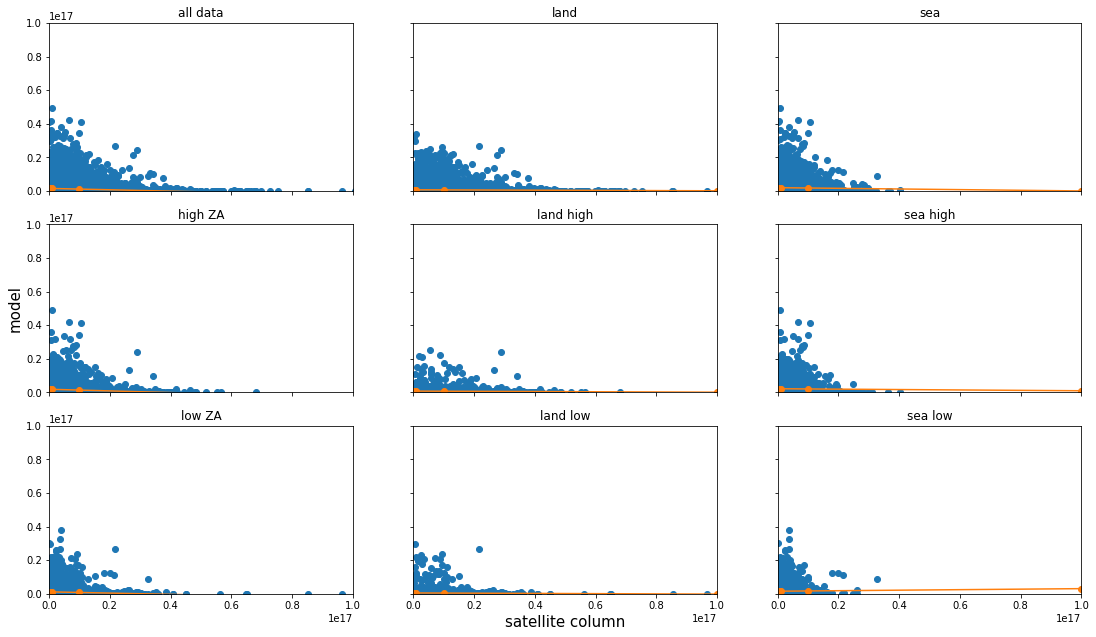

In [10]:
def nh3_plot(cd_plot,ax,titlestring):

    xline = np.array([1e12,1e13,1e14,1e15,1e16,1e17])

    slope, intercept, r_value, p_value, std_err = stats.linregress(cd_plot.column,cd_plot.nh3)
    line = slope*xline+intercept

    #ax.set_xscale("log", nonposx='clip')
    #ax.set_yscale("log", nonposy='clip')
    #ax.scatter(cd_plot.column, cd_plot.nh3)
    ax.plot(cd_plot.column, cd_plot.nh3, 'o', xline, line, 'o-')
    ax.set_title(titlestring)
    ax.set_xlim(1e12,1e17)
    ax.set_ylim(1e12,1e17)

fig, axes = plt.subplots(3, 3, sharex='all', sharey='all')
fig.set_size_inches(18.5, 10.5)
axes[2,1].set_xlabel(r'satellite column', fontsize=15)
axes[1,0].set_ylabel(r'model', fontsize=15)

nh3_plot(cd_all,axes[0,0],"all data")
nh3_plot(cd_land,axes[0,1],"land")
nh3_plot(cd_sea,axes[0,2],"sea")

nh3_plot(cd_high,axes[1,0],"high ZA")
nh3_plot(cd_low,axes[2,0],"low ZA")

nh3_plot(cd_land_high,axes[1,1],"land high")
nh3_plot(cd_sea_high,axes[1,2],"sea high")

nh3_plot(cd_land_low,axes[2,1],"land low")
nh3_plot(cd_sea_low,axes[2,2],"sea low")
